In [13]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from shapely.ops import unary_union

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text, not paths
matplotlib.rcParams['font.family'] = 'Arial'  # Use a widely supported font

# Parameters
n_pts = 3000
min_log10 = -6
max_log10 = 6
n_dim = 4
koff_r2w = 1e3
colors = [
    '#f0f921',  # yellow
    '#f8a53d',  # orange
    '#e16462',  # red
    '#c04378',  # pinkish
    '#b12a90',  # magenta
    '#891c9c',  # violet
    '#6a00a8'   # purple
]
numbers = [7, 6, 5, 4, 3, 2, 1]

# Optimized tradeoff_reaction_expression_n function
def tradeoff_reaction_expression_n(kvec, koff_r2w, n):
    koff, kcat, kon, kp = kvec
    koffw = koff * koff_r2w
    part1_R = (koff + kp)**n
    part1_W = (koffw + kp)**n
    sum_terms = 0
    for i in range(n):
        coefficient = sp.comb(n-1, i, exact=True) * (i + 1)
        term = coefficient * koff**(n-1 - i) * kp**i
        sum_terms += term
    part2_R = kon * sum_terms
    part2_W = kon * sum_terms
    activity = kon * np.power(kp, n) / ((koff + kon) * np.power((koff + kp), n) + kcat * (part1_R + part2_R))
    activity_flux = activity * kcat
    fidelity = ((koffw + kon) * np.power((koffw + kp), n) + kcat * (part1_W + part2_W)) / \
               ((koff + kon) * np.power((koff + kp), n) + kcat * (part1_R + part2_R))
    fidelity_normalized = fidelity / koff_r2w**(n + 1)
    return [activity, fidelity, activity_flux, fidelity_normalized, koff, kcat, kon, kp]

# tradeoff_result_n function
def tradeoff_result_n(kk, koff_r2w, n):
    result_n_x = np.zeros((n_pts, 8))
    for i in range(n_pts):
        result_n_x[i] = tradeoff_reaction_expression_n(kk[i, :], koff_r2w, n)
    return result_n_x

# Set Seaborn context
sns.set_context('talk', font_scale=2, rc={'lines.linewidth': 3})

# Function to create a single plot with colors by n
def create_plot(kk, title, ax, max_points=2000):
    for idx, i in enumerate(numbers):
        result_n_i = tradeoff_result_n(kk, koff_r2w, i) 

        # Randomly select up to `max_points`
        n_total = result_n_i.shape[0]
        if n_total > max_points:
            idx_selected = np.random.choice(n_total, max_points, replace=False)
            result_n_i_selected = result_n_i[idx_selected]

        ax.scatter(result_n_i_selected[:, 1], result_n_i_selected[:, 0], s=20, color=colors[idx % len(colors)], label=f'n = {i}')

        



In [14]:

# Create three kk arrays for different kp conditions
# 1. kp < koff
kk_less_less = np.zeros((n_pts, n_dim))
kk_less_less[:, 0:3] = 10**(np.random.rand(n_pts, 3) * (max_log10 - min_log10) + min_log10)
log_koff = np.log10(kk_less_less[:, 0])
max_log_kp = log_koff-1
log_kp = min_log10 + np.random.rand(n_pts) * (max_log_kp - min_log10)
kk_less_less[:, 3] = 10**log_kp
assert np.all(kk_less_less[:, 3] < kk_less_less[:, 0]), "kp is not less than koff"

# 1. kp < koff
kk_less = np.zeros((n_pts, n_dim))
kk_less[:, 0:3] = 10**(np.random.rand(n_pts, 3) * (max_log10 - min_log10) + min_log10)
log_koff = np.log10(kk_less[:, 0])
max_log_kp = log_koff
log_kp = min_log10 + np.random.rand(n_pts) * (max_log_kp - min_log10)
kk_less[:, 3] = 10**log_kp
assert np.all(kk_less[:, 3] < kk_less[:, 0]), "kp is not less than koff"

# 2. kp = koff
kk_equal = np.zeros((n_pts, n_dim))
kk_equal[:, 0:3] = 10**(np.random.rand(n_pts, 3) * (max_log10 - min_log10) + min_log10)
kk_equal[:, 3] = kk_equal[:, 0]
assert np.all(kk_equal[:, 3] == kk_equal[:, 0]), "kp is not equal to koff"

# 3. kp > koff
kk_greater = np.zeros((n_pts, n_dim))
kk_greater[:, 0:3] = 10**(np.random.rand(n_pts, 3) * (max_log10 - min_log10) + min_log10)
log_koff = np.log10(kk_greater[:, 0])
min_log_kp = log_koff
log_kp = min_log_kp + np.random.rand(n_pts) * (max_log10 - min_log_kp)
kk_greater[:, 3] = 10**log_kp
assert np.all(kk_greater[:, 3] > kk_greater[:, 0]), "kp is not greater than koff"




In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import seaborn as sns

# Set seaborn style
sns.set_context('talk', font_scale=1.8, rc={'lines.linewidth': 2})

# Aggregate all points from different n values
def get_all_points_for_hull(kk, koff_r2w, n_list):
    points = []
    for n in n_list:
        points.append([])
        result = np.array([tradeoff_reaction_expression_n(kvec, koff_r2w, n) for kvec in kk])
        # Use fidelity (x) and activity (y)
        fidelity = result[:, 1]
        activity = result[:, 0]
        # Filter out any invalid or zero values to avoid log-scaling issues
        valid = (fidelity > 0) & (activity > 0)
        log_points = np.log10(np.vstack([fidelity[valid], activity[valid]]).T)
        points[-1].append(log_points)
    return np.vstack(points)

# Example usage with kk_less
kk_less_log_points = get_all_points_for_hull(kk_less, koff_r2w, numbers)
kk_equal_log_points = get_all_points_for_hull(kk_equal, koff_r2w, numbers)
kk_greater_log_points = get_all_points_for_hull(kk_greater, koff_r2w, numbers)

kk_less_less_log_points = get_all_points_for_hull(kk_less_less, koff_r2w, numbers)
#kk_greater_greater_log_points = get_all_points_for_hull(kk_greater_greater, koff_r2w, numbers)



In [16]:

def create_plot_convex(all_log_points,ax, label, color):
 
    hulls = []
    polys = []

    for i in range(len(numbers)):
        hulls.append(ConvexHull(all_log_points[i]))
        polys.append(Polygon(all_log_points[i][hulls[i].vertices]))

    union_poly = unary_union(polys)

    # If you want the convex hull of the union polygon:
    convex_union = Polygon(union_poly.convex_hull)

    # Union fill
    if not union_poly.is_empty:
        x, y = union_poly.exterior.xy
        x = 10**np.array(x)
        y = 10**np.array(y)
        ax.plot(x, y, alpha=1, color= color,lw=5,  label= label)


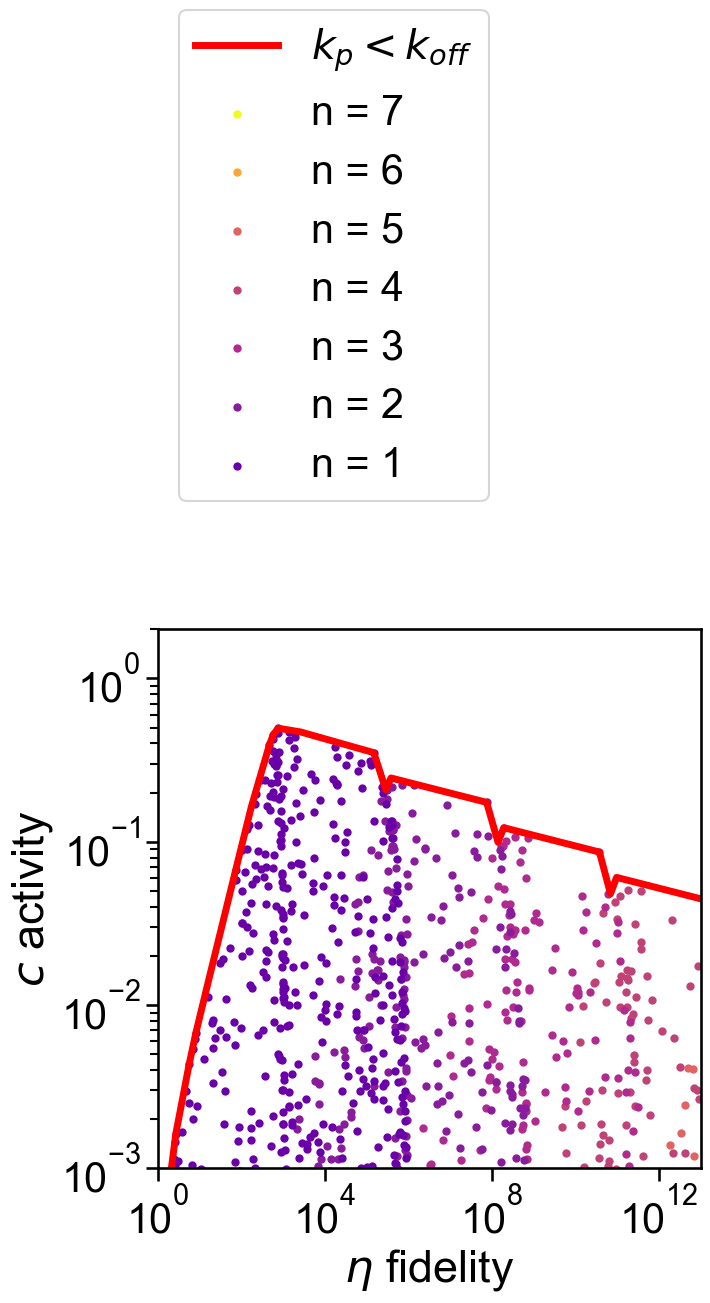

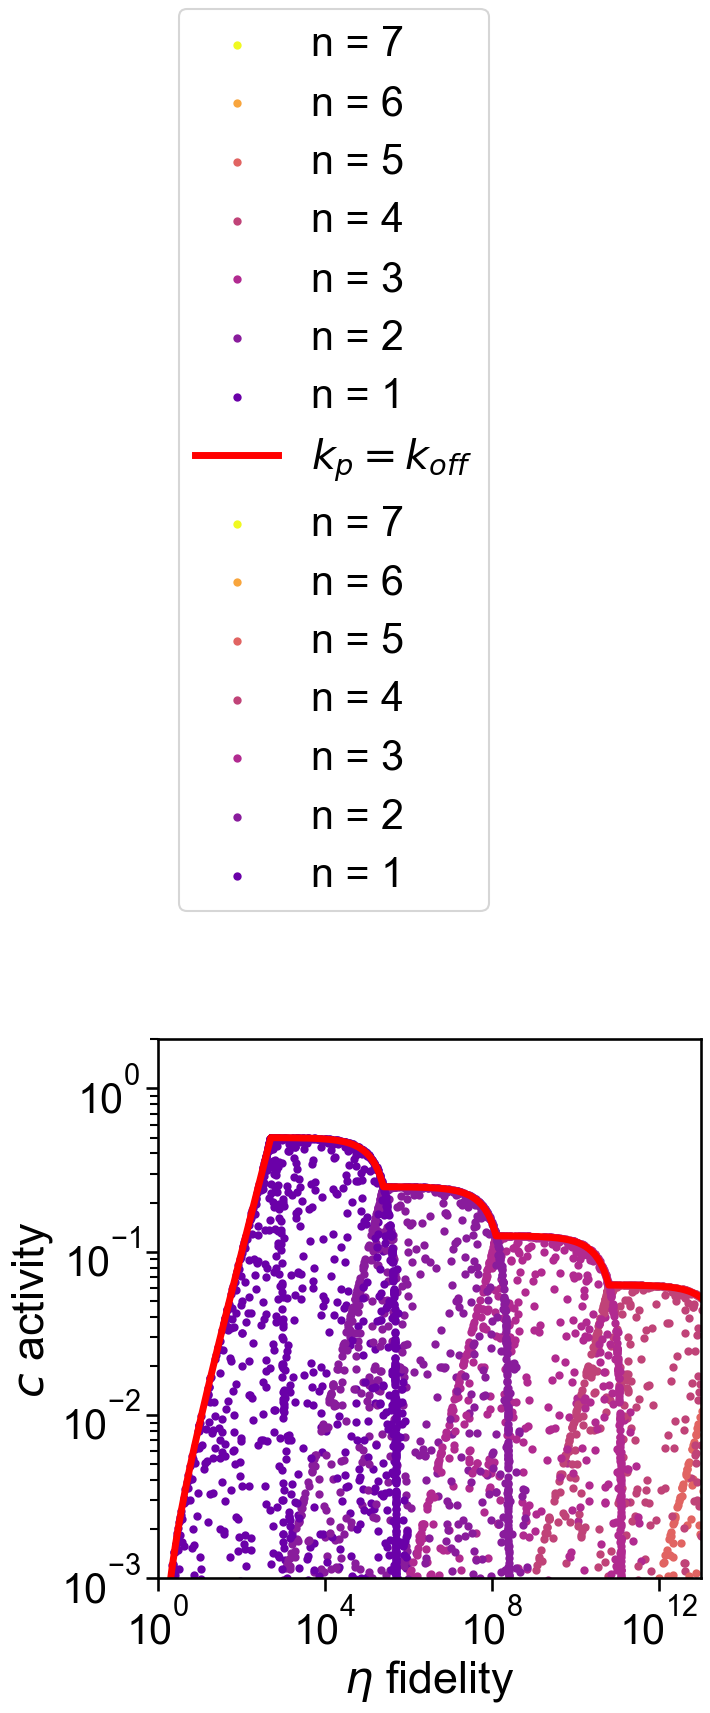

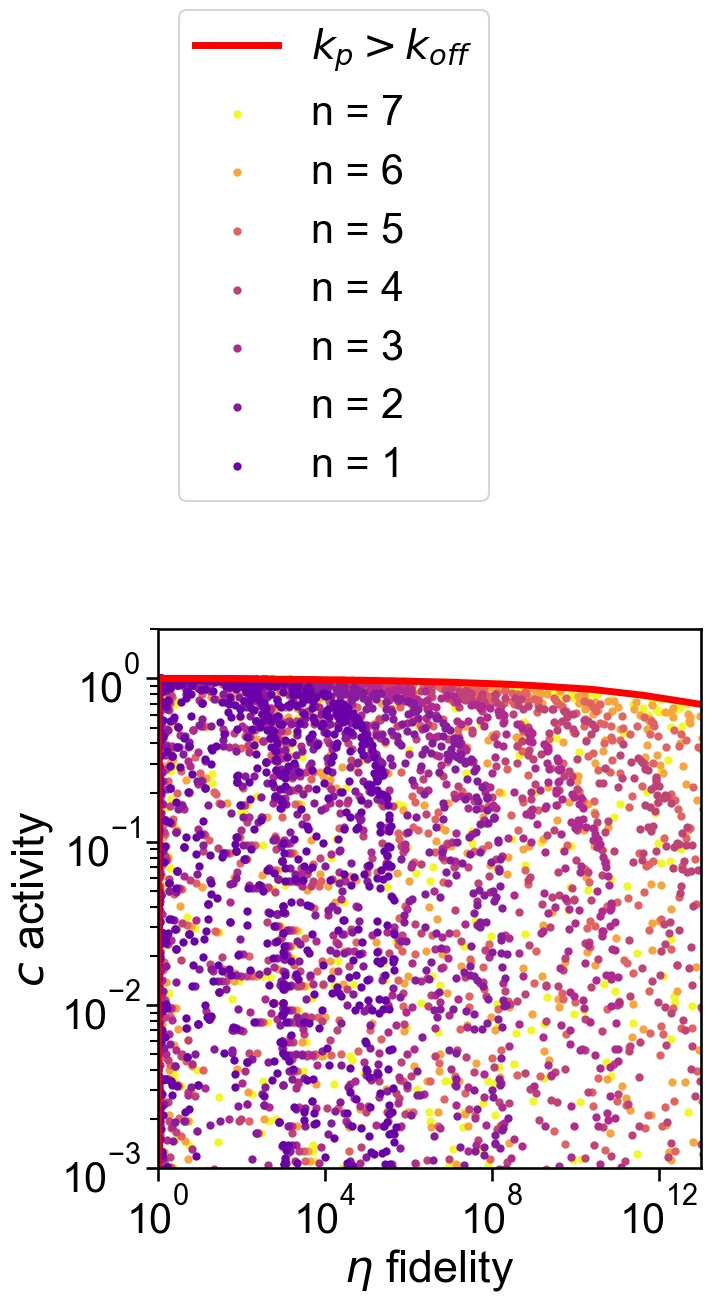

In [22]:
# Create three figures
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 7))

create_plot_convex(kk_less_log_points, ax1, r'$k_p < k_{off}$', 'red')
create_plot(kk_less, r'$k_p < k_{off}$', ax1)

ax1.set_ylabel(r'$c$ activity')
ax1.set_xlabel(r'$\eta$ fidelity')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1, 1e13])
ax1.set_ylim([1e-3, 2])
ax1.legend(bbox_to_anchor=(0, 1.2), loc='lower left')
plt.savefig(f'figure_S5b_1.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close(fig1)

fig2, ax2 = plt.subplots(1, 1, figsize=(7, 7))
create_plot(kk_less, r'$k_p < k_{off}$', ax2)
create_plot_convex(kk_equal_log_points, ax2, r'$k_p = k_{off}$', 'red')
create_plot(kk_equal, r'$k_p = k_{off}$', ax2)
ax2.set_ylabel(r'$c$ activity')
ax2.set_xlabel(r'$\eta$ fidelity')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1, 1e13])
ax2.set_ylim([1e-3, 2])
ax2.legend(bbox_to_anchor=(0, 1.2), loc='lower left')
plt.savefig(f'figure_S5b_2.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close(fig2)


fig3, ax3 = plt.subplots(1, 1, figsize=(7, 7))
create_plot_convex(kk_greater_log_points, ax3, r'$k_p > k_{off}$', 'red')
create_plot(kk_greater, r'$k_p > k_{off}$', ax3)
ax3.set_ylabel(r'$c$ activity')
ax3.set_xlabel(r'$\eta$ fidelity')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1, 1e13])
ax3.set_ylim([1e-3, 2])
ax3.legend(bbox_to_anchor=(0, 1.2), loc='lower left')
plt.savefig(f'figure_S5b_3.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close(fig3)

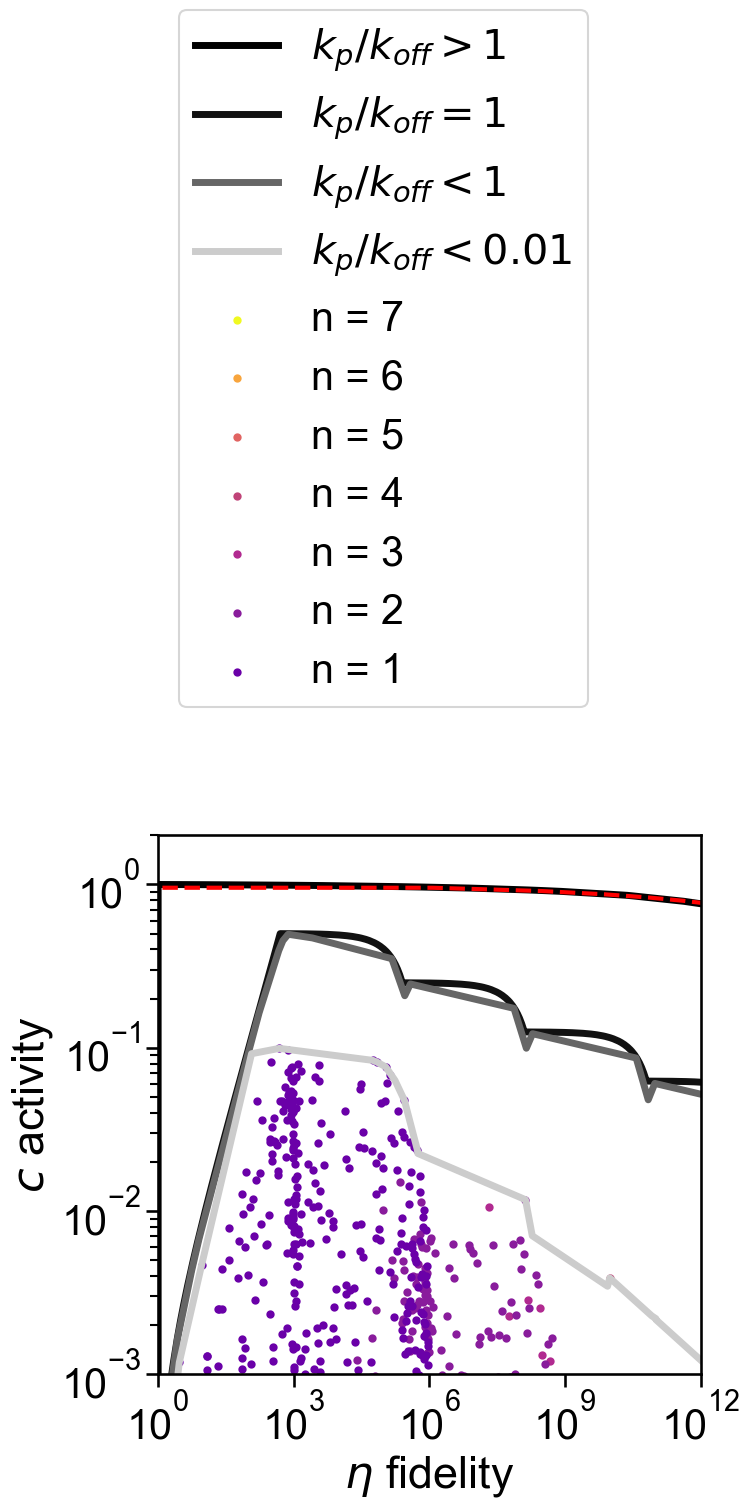

In [18]:
# Create three figures
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 7))

#create_plot(kk_less, r'$k_p < k_{off}$', ax1)
#colors = ['#ff595e', '#ffca3a', '#8ac926', '#1982c4', '#6a4c93', '#ff924c', '#c92c6d']
colors_black = [
    '#ffffff',  # white
    '#cccccc',  # light gray
    '#999999',  # medium-light gray
    '#666666',  # medium gray
    '#333333',  # dark gray
    '#111111',  # very dark gray
    '#000000'   # black
]

create_plot_convex(kk_greater_log_points, ax1, r'$k_p/k_{off} > 1$', color = colors_black[6])
create_plot_convex(kk_equal_log_points, ax1, r'$k_p/k_{off} = 1$', color = colors_black[5])
create_plot_convex(kk_less_log_points, ax1, r'$k_p/k_{off} < 1$', color = colors_black[3])
create_plot_convex(kk_less_less_log_points, ax1, r'$k_p/k_{off} < 0.01$', color = colors_black[1])
create_plot(kk_less_less, r'$k_p < k_{off}$', ax1)

xx = np.logspace(-20, 0, 1000)
ax1.plot((1/xx**(1/(7+1))-1)**(7+1)*xx*(1000**(7+1)), xx, lw=3, color= 'red',
                linestyle='--', alpha=1)

ax1.set_ylabel(r'$c$ activity')
ax1.set_xlabel(r'$\eta$ fidelity')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1, 1e12])
ax1.set_ylim([1e-3, 2])
ax1.legend(bbox_to_anchor=(0, 1.2), loc='lower left')
plt.savefig(f'figure_S5c.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close(fig1)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


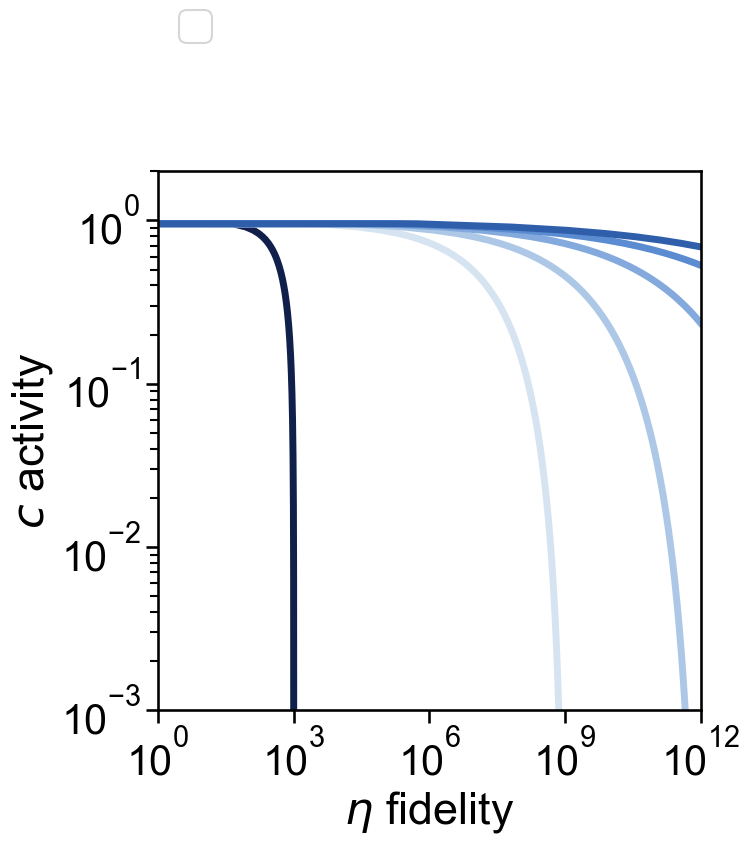

In [19]:
# Create three figures
fig, ax= plt.subplots(1, 1, figsize=(7, 7))
colors_blue = [
    '#10204b',  # very dark blue (almost navy)
    '#2f5faa',  # dark blue
    '#5b8bd0',  # medium blue
    '#84a9dc',  # soft medium blue
    '#adc8e6',  # light blue
    '#d6e4f2',  # very light blue
    '#ffffff'   # white
]

for i, idx in enumerate(numbers):
    xx = np.logspace(-20, 0, 1000)
    ax.plot((1/xx**(1/(i+1))-1)**(i+1)*xx*(1000**(i+1)), xx, lw=5, color=colors_blue[idx % len(colors)],
                    linestyle='-', alpha=1)

ax.set_ylabel(r'$c$ activity')
ax.set_xlabel(r'$\eta$ fidelity')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1, 1e12])
ax.set_ylim([1e-3, 2])
ax.legend(bbox_to_anchor=(0, 1.2), loc='lower left')
plt.savefig(f'figure_S5d.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close(fig1)

